# Image Augmentation and Preprocessing Utilities
This notebook provides utility functions for image preprocessing and augmentation commonly used in deep learning tasks.

In [28]:
# Import necessary libraries
import os
import io
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm


## Image Loading and Preprocessing

In [29]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        PIL.Image: Preprocessed image
    """
    # Load image
    img = Image.open(image_path)

    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize image
    img = img.resize(target_size, Image.Resampling.LANCZOS)

    return img

def load_images_from_directory(directory_path, target_size=(224, 224)):
    """
    Load all images from a directory and preprocess them.

    Args:
        directory_path (str): Path to the directory containing images
        target_size (tuple): Desired output size (width, height)

    Returns:
        list: List of preprocessed images
    """
    images = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}

    for filename in tqdm(os.listdir(directory_path)):
        if os.path.splitext(filename)[1].lower() in valid_extensions:
            image_path = os.path.join(directory_path, filename)
            try:
                img = load_and_preprocess_image(image_path, target_size)
                images.append(img)
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")

    return images

## Image Augmentation Functions

In [30]:
class BasicAugmenter:
    def __init__(self, p=0.5):
        """
        Initialize the augmentation pipeline.

        Args:
            p (float): Probability of applying each augmentation
        """
        self.transform = A.Compose([
            A.HorizontalFlip(p=p),
            A.RandomRotate90(p=p),
            A.VerticalFlip(p=p),
            A.RandomBrightnessContrast(p=p),
            A.RandomCrop(height=178, width=178, p=p),
            A.HueSaturationValue(p=p),
            A.GaussNoise(p=p)
        ])

    def augment(self, image):
        """
        Apply augmentations to an image.

        Args:
            image (PIL.Image): Input image

        Returns:
            PIL.Image: Augmented image
        """
        # Convert PIL image to numpy array
        image_np = np.array(image)

        # Apply augmentations
        augmented = self.transform(image=image_np)['image']

        # Convert back to PIL image
        return Image.fromarray(augmented)

## Segmentation Augmentation
When performing image augmentation for segmentation tasks, we need to ensure that both the input image and its corresponding segmentation mask are transformed in exactly the same way. This ensures that the pixel-wise correspondence between the image and its labels remains intact.

In [31]:
class SegmentationAugmenter:
    def __init__(self, p=0.5, crop_size=(178, 178)):
        """
        Initialize the segmentation augmentation pipeline.

        Args:
            p (float): Probability of applying each augmentation
            crop_size (tuple): Size for random cropping (height, width)
        """
        self.transform = A.Compose([
            A.HorizontalFlip(p=p),
            A.VerticalFlip(p=p),
            A.RandomRotate90(p=p),
            A.RandomCrop(height=crop_size[0], width=crop_size[1], p=p)
        ])

    def augment(self, image, mask):
        """
        Apply augmentations to both the image and its corresponding mask.

        Args:
            image (PIL.Image): Input image
            mask (PIL.Image): Corresponding segmentation mask

        Returns:
            tuple: Augmented image and mask
        """
        # Convert PIL images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Apply augmentations simultaneously to image and mask
        augmented = self.transform(image=image_np, mask=mask_np)
        augmented_image = augmented['image']
        augmented_mask = augmented['mask']

        # Convert back to PIL images
        return Image.fromarray(augmented_image), Image.fromarray(augmented_mask)

## Display Function

In [32]:
def display_augmentations(image, n_examples=5):
    """
    Display original image and multiple augmented versions.

    Args:
        image (PIL.Image): Input image
        n_examples (int): Number of augmented examples to show
    """
    augmenter = BasicAugmenter(p=0.5)

    plt.figure(figsize=(15, 3))

    # Display original image
    plt.subplot(1, n_examples + 1, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')

    # Display augmented versions
    for i in range(n_examples):
        augmented_image = augmenter.augment(image)
        plt.subplot(1, n_examples + 1, i + 2)
        plt.imshow(augmented_image)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [33]:
def display_segmentation_augmentations(image, mask, n_examples=5):
    """
    Display original and augmented image-mask pairs.

    Args:
        image (PIL.Image): Input image
        mask (PIL.Image): Corresponding segmentation mask
        n_examples (int): Number of augmented examples to show
    """
    augmenter = SegmentationAugmenter(p=0.5)

    plt.figure(figsize=(10, 2 * n_examples))

    for i in range(n_examples):
        # Apply augmentation to both image and mask
        augmented = augmenter.transform(image=np.array(image), mask=np.array(mask))
        augmented_image = Image.fromarray(augmented['image'])
        augmented_mask = Image.fromarray(augmented['mask'])

        # Display original
        if i == 0:
            plt.subplot(n_examples, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(n_examples, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title('Original Mask')
            plt.axis('off')

        # Display augmented pair
        plt.subplot(n_examples, 2, (2 * i) + 3)
        plt.imshow(augmented_image)
        plt.title(f'Augmented Image {i + 1}')
        plt.axis('off')

        plt.subplot(n_examples, 2, (2 * i) + 4)
        plt.imshow(augmented_mask, cmap='gray')
        plt.title(f'Augmented Mask {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Testing: Load and augment a single image
To use this code, replace 'path_to_your_image.jpg' with the path to the image and replace image_path variable with the image directory.

<PIL.Image.Image image mode=RGB size=224x224 at 0x1315301B7F0>


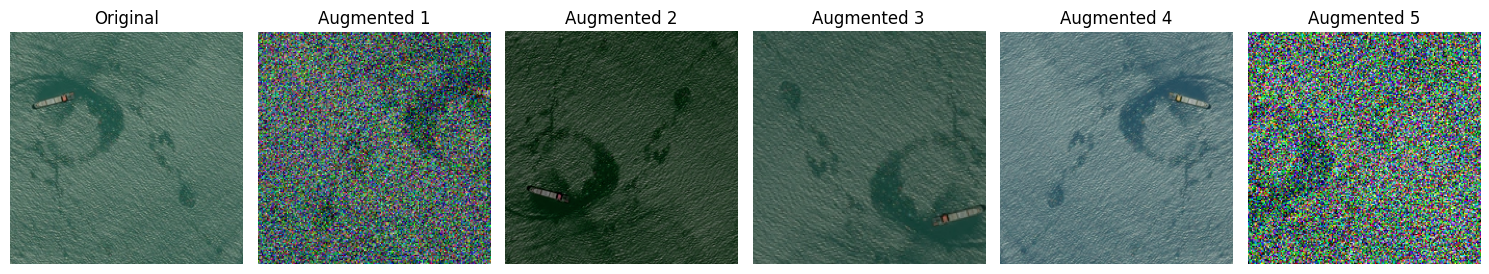

100%|██████████| 3436/3436 [01:10<00:00, 48.91it/s]


In [34]:
# Load and preprocess a single image
image = load_and_preprocess_image('E:/Datasets/MasatiV2/JPEGImages/7bd3a77f3.bmp')
print(image)

# Display original and augmented versions
directory_path = 'E:/Datasets/MasatiV2/JPEGImages/'
display_augmentations(image)

# Load multiple images from a directory
images = load_images_from_directory(directory_path)


# Bounding Box Augmentation
When working with object detection tasks using PASCAL VOC format like the Masati-v2 dataset, one needs to ensure that bounding box coordinates are properly transformed along with the image augmentations. The XML files in the Annotations directory contain:
- Image dimensions and channels
- Class names for each instance
- Bounding box coordinates (xmin, ymin, xmax, ymax)

We'll create a utility class to:
1. Parse XML annotations
2. Apply augmentations to both image and bounding boxes
3. Update the coordinates accordingly
4. Visualize the results


In [35]:
class BoundingBoxAugmenter:
    def __init__(self, p=0.5):
        """
        Initialize the bounding box augmentation pipeline.

        Args:
            p (float): Probability of applying each augmentation
        """
        self.transform = A.Compose([
            A.HorizontalFlip(p=p),
            A.RandomRotate90(p=p),
            A.VerticalFlip(p=p),
            A.RandomBrightnessContrast(p=p)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    def parse_voc_xml(self, xml_path):
        """
        Parse PASCAL VOC annotation XML file.

        Args:
            xml_path (str): Path to XML annotation file

        Returns:
            tuple: (list of bounding boxes, list of class labels)
        """
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        class_labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            class_labels.append(name)

        return boxes, class_labels

    def augment(self, image, boxes, class_labels):
        """
        Apply augmentations to image and bounding boxes.

        Args:
            image (PIL.Image): Input image
            boxes (list): List of bounding boxes in PASCAL VOC format
            class_labels (list): List of class labels

        Returns:
            tuple: (augmented image, augmented boxes, augmented labels)
        """
        # Convert PIL image to numpy array
        image_np = np.array(image)

        # Apply augmentations
        transformed = self.transform(
            image=image_np,
            bboxes=boxes,
            class_labels=class_labels
        )

        return (Image.fromarray(transformed['image']),
                transformed['bboxes'],
                transformed['class_labels'])


In [36]:
def visualize_bbox_augmentation(image, boxes, class_labels, ax=None):
    """
    Visualize an image with its bounding boxes.

    Args:
        image (PIL.Image): Input image
        boxes (list): List of bounding boxes in PASCAL VOC format
        class_labels (list): List of class labels
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If None, current axes will be used
    """
    if ax is None:
        ax = plt.gca()

    # Create figure
    ax.imshow(image)

    # Plot each bounding box
    for box, label in zip(boxes, class_labels):
        xmin, ymin, xmax, ymax = box

        # Create rectangle
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add label
        ax.text(xmin, ymin - 5, label, color='red',
                bbox=dict(facecolor='white', alpha=0.7))

    ax.axis('off')


In [37]:
def display_bbox_augmentations(image_path, xml_path, n_examples=5):
    """
    Display original image and multiple augmented versions with bounding boxes.

    Args:
        image_path (str): Path to the input image
        xml_path (str): Path to the corresponding XML annotation file
        n_examples (int): Number of augmented examples to show
    """
    # Initialize augmenter
    augmenter = BoundingBoxAugmenter(p=0.5)

    # Load image
    image = Image.open(image_path)

    # Parse XML annotations
    boxes, class_labels = augmenter.parse_voc_xml(xml_path)

    # Create figure
    fig, axes = plt.subplots(1, n_examples + 1, figsize=(20, 5))

    # Show original
    axes[0].set_title('Original')
    visualize_bbox_augmentation(image, boxes, class_labels, ax=axes[0])

    # Show augmented versions
    for i in range(n_examples):
        axes[i + 1].set_title(f'Augmented {i + 1}')

        # Apply augmentation
        aug_image, aug_boxes, aug_labels = augmenter.augment(image, boxes, class_labels)

        # Visualize
        visualize_bbox_augmentation(aug_image, aug_boxes, aug_labels, ax=axes[i + 1])

    plt.tight_layout()
    plt.show()


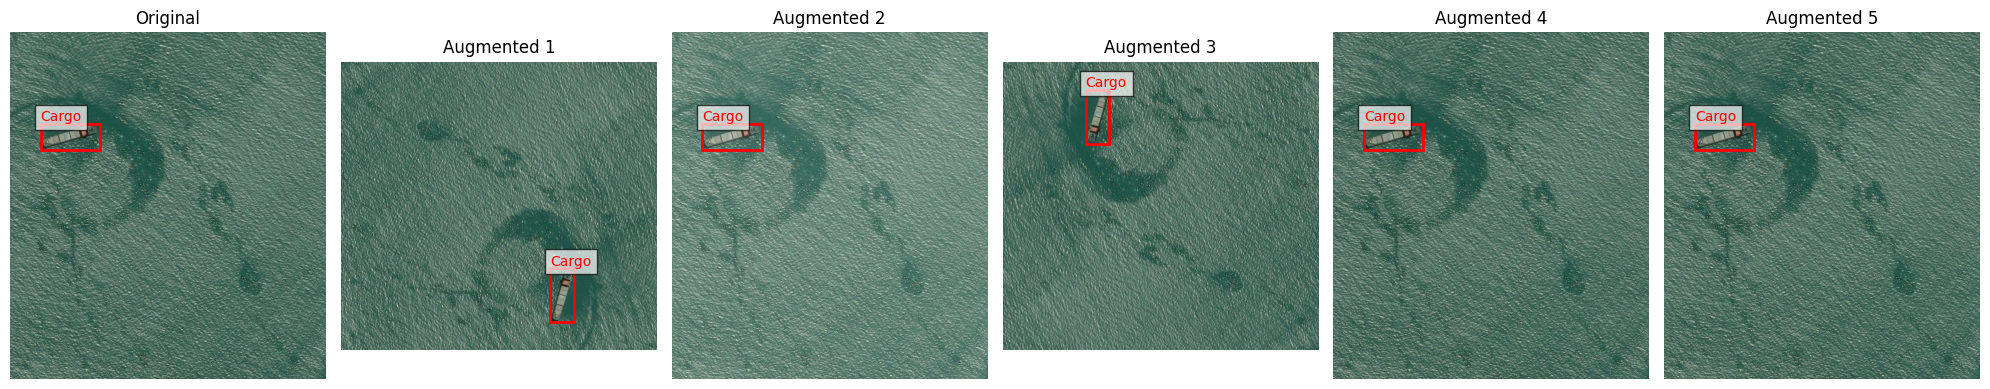

In [38]:
# Example usage with actual paths
image_path = "E:/Datasets/MasatiV2/JPEGImages/7bd3a77f3.bmp"
xml_path = "E:/Datasets/MasatiV2/Annotations/7bd3a77f3.xml"
display_bbox_augmentations(image_path, xml_path)

## Calculate: Augmented Dataset Size

In [39]:
def calculate_augmented_dataset_size(n_original_images, augmentations_per_image=5,
                                     original_image_size_mb=None, sample_image=None):
    """
    Calculate the approximate dataset size after augmentation.

    Args:
        n_original_images (int): Number of images in original dataset
        augmentations_per_image (int): Number of augmented versions per original image
        original_image_size_mb (float, optional): Average size of one image in MB
        sample_image (PIL.Image, optional): Sample image to calculate average size

    Returns:
        dict: Dictionary containing:
            - total_images: Total number of images after augmentation
            - original_size_mb: Approximate size of original dataset in MB
            - augmented_size_mb: Approximate size of augmented dataset in MB
    """
    # Calculate total number of images after augmentation
    total_images = n_original_images * (augmentations_per_image + 1)  # +1 for original images

    # If image size not provided, try to calculate from sample image
    if original_image_size_mb is None and sample_image is not None:
        # Convert PIL image to bytes and calculate size in MB
        with io.BytesIO() as bio:
            sample_image.save(bio, format='BMP')
            original_image_size_mb = len(bio.getvalue()) / (1024 * 1024)

    # Calculate sizes if we have image size information
    if original_image_size_mb is not None:
        original_size_mb = n_original_images * original_image_size_mb
        augmented_size_mb = total_images * original_image_size_mb
    else:
        original_size_mb = None
        augmented_size_mb = None

    return {
        'total_images': total_images,
        'original_size_mb': original_size_mb,
        'augmented_size_mb': augmented_size_mb
    }

In [40]:
# With a sample image
result = calculate_augmented_dataset_size(
    n_original_images=len(images),
    augmentations_per_image=5,
    sample_image=image  # Using the loaded image
)

print(f"Total images after augmentation: {result['total_images']}")
print(f"Original dataset size: {result['original_size_mb']:.2f} MB")
print(f"Augmented dataset size: {result['augmented_size_mb']:.2f} MB")


Total images after augmentation: 20616
Original dataset size: 493.43 MB
Augmented dataset size: 2960.59 MB
